# Sequence-to-Sequence Character Prediction: Comparing RNN, LSTM, and GRU Architectures

## Task to perform

Given an input sequence of lowercase English letters, the model should predict the same sequence with each character shifted forward by 1 in the alphabet.

Example:
Input: "abcxyz" → Target: "bcdyza"

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt
import random
import string
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Synthesizing data

In [242]:
vocab = ["<pad>"] + list(string.ascii_lowercase)
vocab_size = len(vocab)
char_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

print(idx_to_char)

{0: '<pad>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [243]:
def shift_letter(char):
    return chr((ord(char) - ord("a") + 1) % 26 + ord("a"))


def generate_sample(n=5000):
    x_data, y_data = [], []
    for _ in range(n):
        word = "".join(random.choices(string.ascii_lowercase, k=26))

        shifted = "".join(shift_letter(c) for c in word)
        x_data.append([char_to_idx[c] for c in word])
        y_data.append([char_to_idx[c] for c in shifted])
    return x_data, y_data


def text_to_indices(text, char_to_index):
    return [char_to_index[c] for c in text]


# Plot function

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

# Training setup

In [ ]:
x_train, y_train = generate_sample()
x_train = pad_sequences(x_train, maxlen=26, padding="post")
y_train = pad_sequences(y_train, maxlen=26, padding="post")

x_train, x_test, y_train, y_test =  train_test_split(x_train, y_train, test_size=0.2)

early_stop = EarlyStopping(monitor="accuracy", patience=3, restore_best_weights=True)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Training RNN

In [ ]:
rnn_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        SimpleRNN(64, return_sequences=True),
        Dense(vocab_size, activation="softmax"),
    ]
)

rnn_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [247]:
rnn_history = rnn_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2186 - loss: 3.1801 - val_accuracy: 0.7037 - val_loss: 2.7191 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8133 - loss: 2.4710 - val_accuracy: 0.9896 - val_loss: 1.5678 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 1.2304 - val_accuracy: 1.0000 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.3099 - val_accuracy: 1.0000 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0930 - val_accuracy: 1.0000 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 1.0000 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 1.0000 - v

# Training LSTM

In [ ]:
lstm_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        LSTM(64, return_sequences=True),
        Dense(vocab_size, activation="softmax"),
    ]
)

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [249]:
lstm_history = lstm_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2789 - loss: 3.2554 - val_accuracy: 0.3897 - val_loss: 3.0612 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5648 - loss: 2.9068 - val_accuracy: 0.9193 - val_loss: 2.1239 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9621 - loss: 1.7232 - val_accuracy: 1.0000 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.5114 - val_accuracy: 1.0000 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.1679 - val_accuracy: 1.0000 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0855 - val_accuracy: 1.0000 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0539 - val_acc

# Training GRU

In [250]:
gru_model = Sequential(
    [
        Embedding(input_dim=vocab_size, output_dim=32),
        GRU(64, return_sequences=True), 
        Dense(vocab_size, activation="softmax"),
    ]
)

gru_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [251]:
gru_history = gru_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, lr_schedule])

Epoch 1/20


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6540 - loss: 3.1905 - val_accuracy: 0.9791 - val_loss: 2.7120 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9756 - loss: 2.3946 - val_accuracy: 1.0000 - val_loss: 1.1888 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.8458 - val_accuracy: 1.0000 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.1549 - val_accuracy: 1.0000 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0568 - val_accuracy: 1.0000 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.0253 - learning_rate: 0.0010


# Plotting Graphs & Accuracy

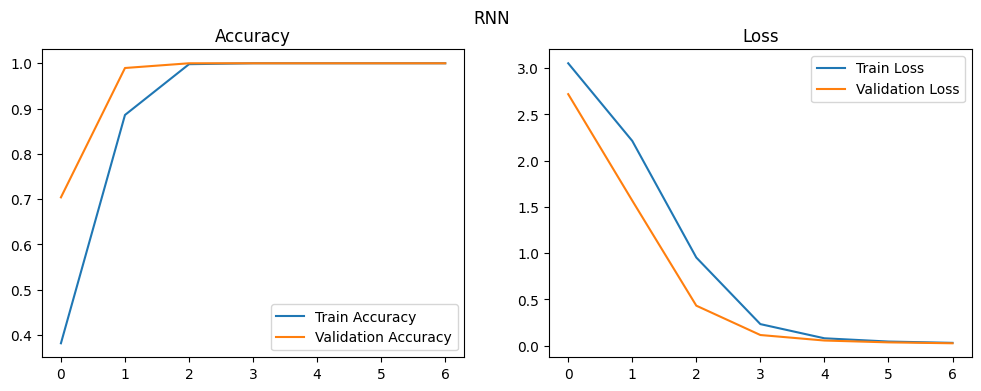

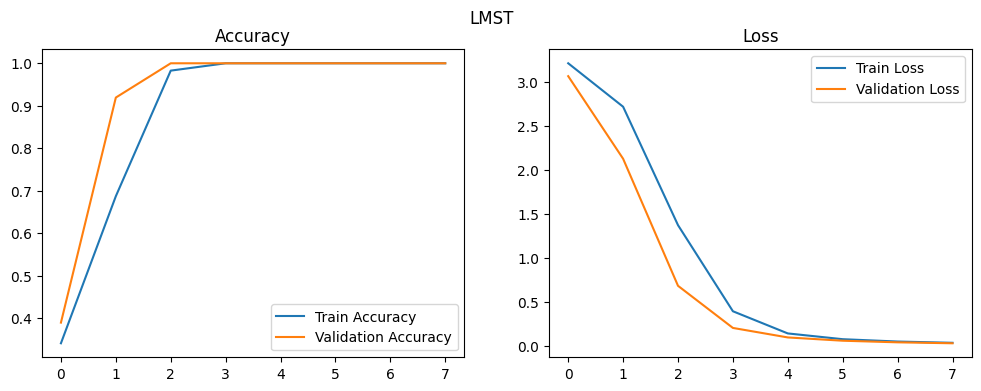

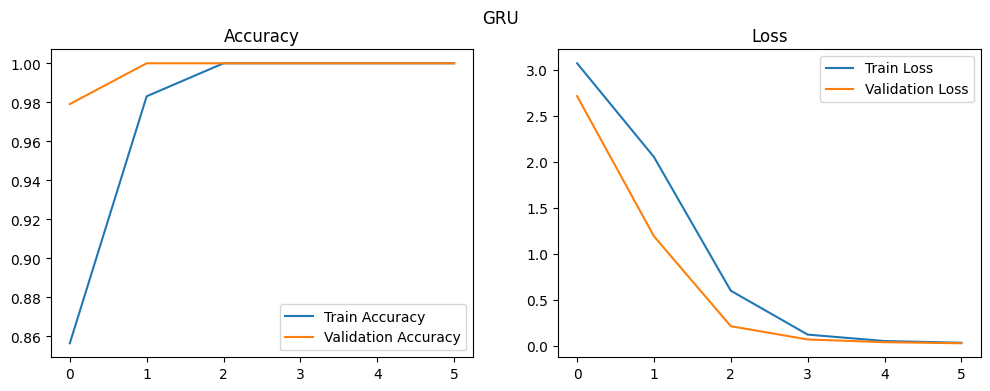

In [252]:
plot_history(rnn_history, "RNN")
plot_history(lstm_history, "LMST")
plot_history(gru_history, "GRU")

In [253]:
test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print(f"RNN Accuracy: {test_acc}")
test_loss, test_acc = lstm_model.evaluate(x_test, y_test)
print(f"LMST Accuracy: {test_acc}")
test_loss, test_acc = gru_model.evaluate(x_test, y_test)
print(f"GRU Accuracy: {test_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1137
RNN Accuracy: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0966
LMST Accuracy: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2107
GRU Accuracy: 1.0


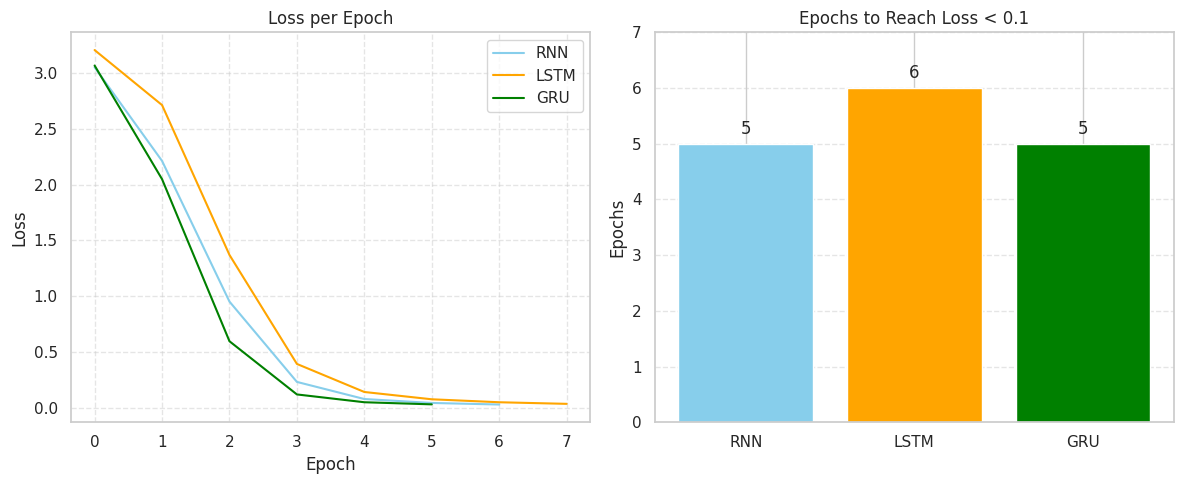

In [ ]:
rnn_loss = rnn_history.history['loss']
lstm_loss = lstm_history.history['loss']
gru_loss = gru_history.history['loss']

def get_convergence_epoch(losses, threshold=0.1):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i + 1
    return len(losses)

rnn_epoch = get_convergence_epoch(rnn_loss)
lstm_epoch = get_convergence_epoch(lstm_loss)
gru_epoch = get_convergence_epoch(gru_loss)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(rnn_loss, label='RNN', color='skyblue')
axes[0].plot(lstm_loss, label='LSTM', color='orange')
axes[0].plot(gru_loss, label='GRU', color='green')
axes[0].set_title("Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

models = ["RNN", "LSTM", "GRU"]
epochs = [rnn_epoch, lstm_epoch, gru_epoch]
colors = ["skyblue", "orange", "green"]

axes[1].bar(models, epochs, color=colors)
axes[1].set_title("Epochs to Reach Loss < 0.1")
axes[1].set_ylabel("Epochs")
axes[1].set_ylim(0, max(epochs) + 1)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

for i, epoch in enumerate(epochs):
    axes[1].text(i, epoch + 0.1, str(epoch), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Summary

### Task to perform

Given an input sequence of lowercase English letters, the model should predict the same sequence with each character shifted forward by 1 in the alphabet.

Example:
Input: "abcxyz" → Target: "bcdyza"

### Dataset Configuration

| Parameter          | Value                          |
|--------------------|--------------------------------|
| Vocabulary         | a-z (26 lowercase letters)    |
| Sequence Length    | 26 characters                 |
| Number of Samples  | 5,000 sequences               |
| Character Encoding | a=1 to z=25, padding=0        |
| Target Format      | Sequence of class indices     |



### Model & Training Configuration

| Component               | Specification                          |
|-------------------------|----------------------------------------|
| Embedding Layer         | output_dim=32                         |
| Recurrent Layer Options | SimpleRNN/LSTM/GRU (64 units)         |
| Output Layer            | Dense(26, activation='softmax')       |
| Loss Function           | Sparse categorical crossentropy       |
| Optimizer               | Adam                                  |
| Metrics                 | Accuracy                              |
| Epochs                  | 20 (early stopping at 5-7 epochs)     |
| Batch Size              | 128                                   |
| Validation Split        | 20%                                   |

### Performance Analysis

The training loss vs epochs for all three models is shown in the figure. Key observations:

- GRU converges the fastest, achieving near-zero loss by epoch 4.

- RNN follows closely but is less stable in the initial epochs.

- LSTM starts with a higher loss and converges more gradually.

All models eventually reach 100% training accuracy, indicating that the task is linearly separable and sufficiently simple for all architectures to solve.